In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

sns.set_theme(style="whitegrid", context='paper')

In [57]:
symps = pd.read_csv('data/bias_symptoms.csv', index_col=[0,1])

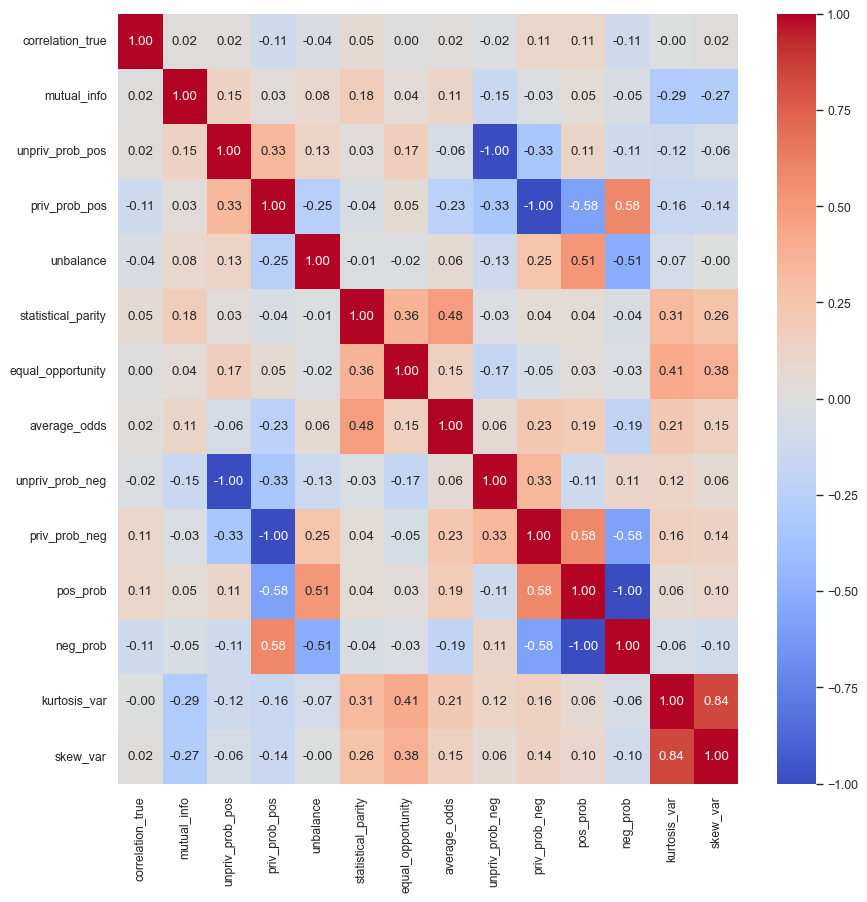

In [58]:
plt.figure(figsize=(10, 10))
sns.heatmap(symps.corr(method='kendall'), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [59]:
symps = pd.read_csv('data/bias_symptoms.csv', index_col=[0,1])

In [60]:
symps

,,correlation_true,mutual_info,unpriv_prob_pos,priv_prob_pos,unbalance,statistical_parity,equal_opportunity,average_odds,unpriv_prob_neg,priv_prob_neg,pos_prob,neg_prob,kurtosis_var,skew_var
variable,data,,,,,,,,,,,,,,
race,adult,0.084531,0.004036,0.129252,0.252500,0.536785,0.0,0.0,1.0,0.870748,0.747500,-0.123248,0.123248,5.639858,-2.763370
sex,adult,0.230065,0.029482,0.101744,0.310378,0.422546,0.0,0.0,0.0,0.898256,0.689622,-0.208634,0.208634,-1.501940,-0.706421
10th,adult,-0.079627,0.004225,0.246914,0.051546,1.025437,0.0,0.0,1.0,0.753086,0.948454,0.195367,-0.195367,26.974784,5.381203
11th,adult,-0.091252,0.005677,0.248489,0.043103,1.031979,0.0,0.0,1.0,0.751511,0.956897,0.205385,-0.205385,21.748435,4.871794
12th,adult,-0.051403,0.001712,0.243518,0.063830,1.011336,0.0,0.0,1.0,0.756482,0.936170,0.179688,-0.179688,60.945596,7.931343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
type,wine,0.085865,0.005864,0.384615,0.476510,0.852241,0.0,0.0,0.0,0.615385,0.523490,-0.091895,0.091895,-0.975126,-1.013928
alcohol,wine,0.363793,0.081020,0.404580,0.497175,0.883764,1.0,0.0,1.0,0.595420,0.502825,-0.092595,0.092595,-1.914522,-0.302827
type,wine,0.142046,0.013685,0.416667,0.469008,0.910165,1.0,0.0,1.0,0.583333,0.530992,-0.052342,0.052342,-0.051297,-1.396023


In [61]:
def plot_differences(symps, symp, symp_name):
    corr_high_sp = symps[symps["statistical_parity"] == 1][symp].values
    corr_low_sp = symps[symps["statistical_parity"] == 0][symp].values
    corr_high_eo = symps[symps["equal_opportunity"] == 1][symp].values
    corr_low_eo = symps[symps["equal_opportunity"] == 0][symp].values
    corr_high_ao = symps[symps["average_odds"] == 1][symp].values
    corr_low_ao = symps[symps["average_odds"] == 0][symp].values
    df = pd.DataFrame(
        {
            symp_name: [
                corr_high_sp,
                corr_low_sp,
                corr_high_eo,
                corr_low_eo,
                corr_high_ao,
                corr_low_ao,
            ],
            "Metric": [
                "Statistical Parity",
                "Statistical Parity",
                "Equal Opportunity",
                "Equal Opportunity",
                "Average Odds",
                "Average Odds",
            ],
            "Bias": ["High", "Low", "High", "Low", "High", "Low"],
        }
    )
    df = df.explode(symp_name)
    g = sns.FacetGrid(df, col="Metric", height=5, aspect=0.5)
    g.map(
        sns.barplot,
        "Bias",
        symp_name,
        "Bias",
        order=["Low", "High"],
        hue_order=["Low", "High"],
        palette=sns.color_palette()[:2],
    )
    g.add_legend()
    g.set_axis_labels("", "Mutual Information")
    plt.show()
    print(ttest_ind(corr_high_sp, corr_low_sp, equal_var=False))
    print(ttest_ind(corr_high_eo, corr_low_eo, equal_var=False))
    print(ttest_ind(corr_high_ao, corr_low_ao, equal_var=False))

## Analysis of Mutual Information

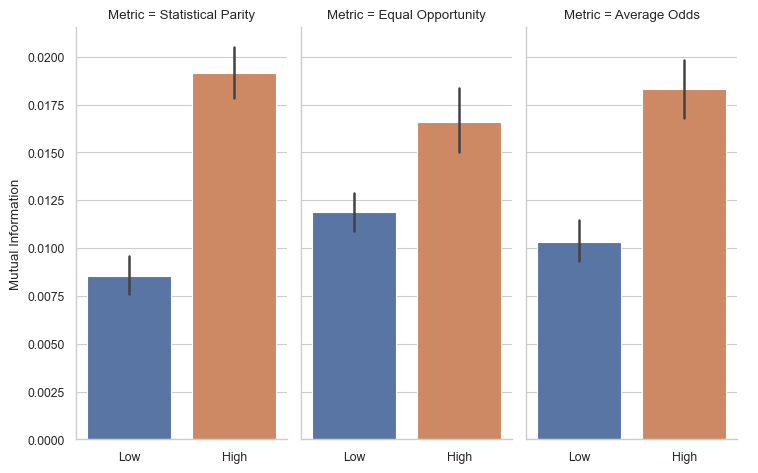

TtestResult(statistic=12.181259491235245, pvalue=1.1050329735503381e-33, df=5273.542215517817)
TtestResult(statistic=4.969556617657444, pvalue=6.981220136577633e-07, df=4148.467645721216)
TtestResult(statistic=8.787038962485973, pvalue=2.118614327152681e-18, df=4698.47871442909)


In [62]:
plot_differences(symps, "mutual_info", "Mutual Information")

## Correlation

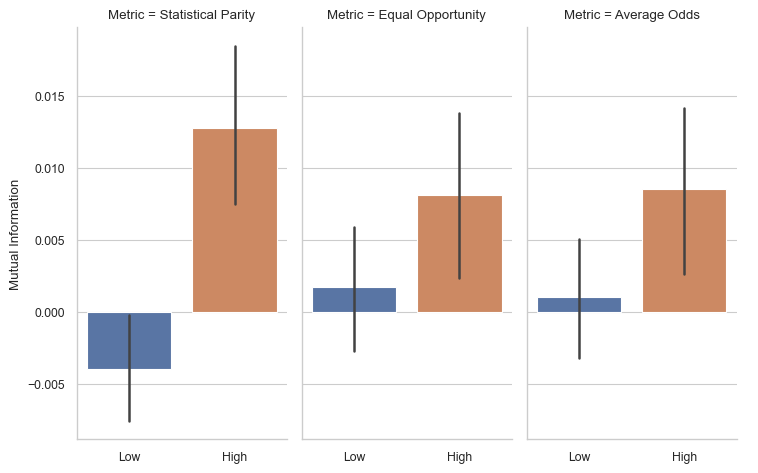

TtestResult(statistic=4.920407206060938, pvalue=8.90281128912713e-07, df=5200.347519522351)
TtestResult(statistic=1.8430507055195777, pvalue=0.06538212656436813, df=4887.272983939778)
TtestResult(statistic=2.1191451882889845, pvalue=0.034130380173150454, df=4710.563657264576)


In [63]:
plot_differences(symps, "correlation_true", "Kendall's Tau")

## Metrics Distribution

In [64]:
distr = pd.DataFrame(
    [
        {
            "Statistical Parity": [
              symps[symps["statistical_parity"] == 0].shape[0]/symps.shape[0],
              symps[symps["statistical_parity"] == 1].shape[0]/symps.shape[0],
            ],
            "Equal Opportunity": [
              symps[symps["equal_opportunity"] == 0].shape[0]/symps.shape[0],
              symps[symps["equal_opportunity"] == 1].shape[0]/symps.shape[0],
            ],
            "Average Odds": [
              symps[symps["average_odds"] == 0].shape[0]/symps.shape[0],
              symps[symps["average_odds"] == 1].shape[0]/symps.shape[0],
            ],
            "Bias": ["Low", "High"]
        }
    ]
)

In [65]:
distr = distr.explode(['Statistical Parity', 'Equal Opportunity', 'Average Odds', 'Bias']).melt(id_vars='Bias', var_name='Metric', value_name='Proportion')

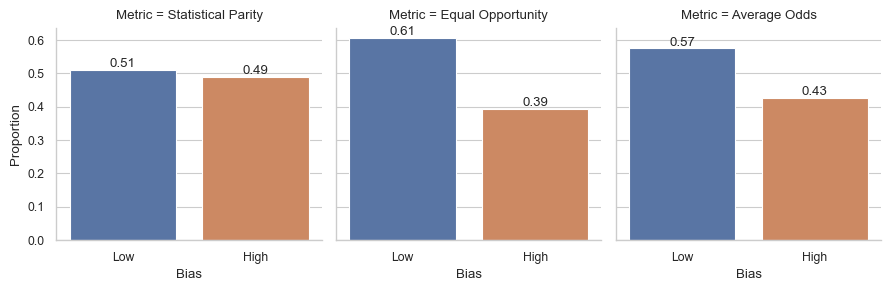

In [66]:
g = sns.catplot(
    data=distr,
    col="Metric",
    x="Bias",
    y="Proportion",
    kind="bar",
    hue="Bias",
    palette=sns.color_palette()[:2],
    height=3,
    aspect=1,
)


g.facet_axis(0, 0).bar_label(g.facet_axis(0, 0).containers[0], fmt="%.2f")
g.facet_axis(0, 0).bar_label(g.facet_axis(0, 0).containers[1], fmt="%.2f")
g.facet_axis(0, 1).bar_label(g.facet_axis(0, 1).containers[0], fmt="%.2f")
g.facet_axis(0, 1).bar_label(g.facet_axis(0, 1).containers[1], fmt="%.2f")
g.facet_axis(0, 2).bar_label(g.facet_axis(0, 2).containers[0], fmt="%.2f")
g.facet_axis(0, 2).bar_label(g.facet_axis(0, 2).containers[1], fmt="%.2f")
plt.savefig('metrics_distr.png', dpi=300, bbox_inches='tight')
plt.show()